In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

### <font color="orange">  **Data Loading, Preprocessing** </font>

In [3]:
df = pd.read_csv('health_insurance_train.csv')
df_autograder = pd.read_csv('health_insurance_autograde.csv')
pd.options.display.float_format = '{:.2f}'.format

# Define a function to convert education ranges to numerical values
def convert_education(education):

    education = education.replace('years', '')

    if '>16' in education:
        return 18
    
    if '<9' in education:
        return 6

    education = education.split('-')
    education = (float(education[-1])+float(education[0]))/2

    return education

# Define a function to convert yes/no values to binary values
def yes_no_True_False_to_binary(value):
    if value == 'yes' or value == 'no':
        if value == 'yes':
            return 1
        else:
            return -1
        
    if value == True or value == False:
        if value == True:
            return 1
        else:
            return 0

    return value

# Define a function to convert NaN values to the mean of the column
def nan_to_mean(value, mean):
    if pd.isna(value):
        return mean
    return value

# Define a function apply all conversion functions to the dataframe
def preprocess_data(df):
    # Apply the conversion functions to the education column
    df['education'] = df['education'].apply(convert_education)

    # Apply one-hot encoding to the race and region column

    ''''
    One hot encoding is a process by which categorical variables are converted into
    binary True/False. ML algorithm will read True as 1 and False as 0. So gradients
    can be made for each column separetely.

    '''
    df = pd.get_dummies(df, columns=['race'], prefix='race',dummy_na=True)
    df = pd.get_dummies(df, columns=['region'],prefix='reg')
    df = pd.get_dummies(df, columns=['hispanic'],prefix='hisp')


    # Apply binary conversion to all remaining columns that contain yes/no or True/False values
    for key in df.keys():
        df[key] = df[key].apply(yes_no_True_False_to_binary)

    # Apply the mean conversion to all columns that contain NaN values
    ''''
    Now that all columns are already converted to numerical values, we can apply the
    mean conversion to all columns that contain NaN values.

    '''

    for key in df:
        mean = df[key].mean()
        df[key] = df[key].apply(lambda x: nan_to_mean(x, mean))

    return df

df_pp = preprocess_data(df)
df_autograder_pp = preprocess_data(df_autograder)

In [4]:
display(df_pp.iloc[9:30])

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,race_nan,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
9,40.00,-1,1,1,12.00,9.00,1.00,1.00,18.00,0,0,1,0,0,0,0,1,1,0
10,40.00,-1,-1,-1,12.00,33.00,0.00,0.00,0.00,0,0,1,0,0,1,0,0,1,0
11,40.00,-1,-1,-1,10.00,5.50,1.00,0.00,20.00,0,0,1,0,1,0,0,0,1,0
12,35.00,-1,1,-1,12.00,26.00,0.00,1.00,0.00,0,0,0,1,0,0,1,0,0,1
13,45.00,-1,1,1,16.00,7.00,0.00,0.00,40.00,0,0,1,0,0,0,1,0,1,0
14,0.00,1,-1,1,12.00,38.00,0.00,0.00,0.00,0,0,1,0,0,1,0,0,1,0
15,20.00,1,-1,1,12.00,9.00,1.00,1.00,33.00,0,0,1,0,0,0,1,0,1,0
16,0.00,1,-1,1,12.00,3.00,0.34,0.70,4.37,1,0,0,0,0,0,0,1,1,0
17,40.00,-1,1,1,12.00,30.00,0.00,0.00,60.00,0,0,1,0,0,1,0,0,0,1
18,0.00,1,-1,1,14.00,34.00,0.00,0.00,100.00,0,0,1,0,0,1,0,0,1,0


In [5]:
display(df_autograder_pp.iloc[0:20])

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,race_nan,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,16.00,25.00,0.00,0.00,0.00,0,0,1,0,0,0,0,1,1,0
1,-1,-1,-1,12.00,41.00,0.00,0.00,0.00,0,0,1,0,0,0,1,0,1,0
2,1,1,1,18.00,21.00,0.00,2.00,34.30,0,0,1,0,0,1,0,0,1,0
3,-1,1,1,10.00,46.50,0.00,0.00,0.00,0,0,0,1,0,1,0,0,1,0
4,-1,-1,-1,14.00,9.00,0.00,0.00,25.00,0,0,1,0,1,0,0,0,1,0
5,1,-1,1,14.00,29.00,0.00,0.00,14.16,0,0,1,0,1,0,0,0,1,0
6,1,-1,1,14.00,12.00,0.00,0.00,2.50,0,0,1,0,1,0,0,0,1,0
7,-1,-1,-1,12.00,4.00,0.00,0.00,30.00,0,0,1,0,0,0,1,0,1,0
8,1,1,1,14.00,35.00,0.00,0.00,52.86,0,0,1,0,0,0,1,0,1,0
9,-1,1,-1,16.00,1.00,0.00,0.00,5.00,0,0,1,0,1,0,0,0,1,0


In [6]:
########### Pipeline Configuration ##############
specific_scaling = True
filter_outliers = True
best_model_picker = True
logistic_adjustment = True


#Pipeline 1 --> False,False
#Pipeline 2 --> True,True
#################################################


### <font color="orange">  **Scaling** </font>

In [7]:
df_pp_mean = df_pp.mean(axis=0)
df_pp_std = df_pp.std(axis=0)

Y_mean = df_pp_mean[0]
Y_std = df_pp_std[0]

if specific_scaling:
    def scale_specifically(df, mean, std, columns_index=[0, 4, 5, 6, 7, 8]):
        df_scaled = df.copy()
        for i in range(len(df.columns)):
            if i in columns_index:
                df_scaled.iloc[:, i] = (df_scaled.iloc[:, i] - mean.iloc[i]) / std.iloc[i]
        return df_scaled


    df_scaled = scale_specifically(df_pp, df_pp_mean, df_pp_std, columns_index=[0, 4, 5, 6, 7, 8])
    df_autograder_scaled = scale_specifically(df_autograder_pp, df_pp_mean.iloc[1:], df_pp_std.iloc[1:], columns_index=[3,4,5,6,7])

else:
    df_scaled = (df_pp - df_pp_mean) / df_pp_std
    df_autograder_scaled = (df_autograder_pp - df_pp_mean.iloc[1:]) / df_pp_std.iloc[1:]

C:\Users\yanca\AppData\Local\Temp\ipykernel_36980\1981104028.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_mean = df_pp_mean[0]
C:\Users\yanca\AppData\Local\Temp\ipykernel_36980\1981104028.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_std = df_pp_std[0]


In [8]:
df_scaled.head()

,whrswk,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,race_nan,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,0.77,-1,1,1,0.36,-0.51,-0.55,0.31,-0.22,0,0,1,0,0,0,1,0,1,0
1,0.77,-1,1,1,0.36,-1.63,1.07,-0.75,-0.52,0,0,1,0,0,0,1,0,1,0
2,-1.37,1,-1,1,1.11,-0.16,-0.55,0.31,3.06,0,0,1,0,0,1,0,0,1,0
3,0.77,-1,-1,1,0.36,-0.08,0.00,-0.00,1.38,0,0,1,0,1,0,0,0,1,0
4,0.50,-1,1,-1,-0.40,-0.68,-0.55,1.37,-1.15,0,0,1,0,0,0,1,0,1,0


In [9]:
df_autograder_scaled.head()

,hhi,whi,hhi2,education,experience,kidslt6,kids618,husby,race_black,race_other,race_white,race_nan,reg_northcentral,reg_other,reg_south,reg_west,hisp_no,hisp_yes
0,-1,1,-1,1.11,0.18,-0.55,-0.75,-1.15,0,0,1,0,0,0,0,1,1,0
1,-1,-1,-1,-0.40,1.57,-0.55,-0.75,-1.15,0,0,1,0,0,0,1,0,1,0
2,1,1,1,1.87,-0.16,-0.55,1.37,0.30,0,0,1,0,0,1,0,0,1,0
3,-1,1,1,-1.16,2.04,-0.55,-0.75,-1.15,0,0,0,1,0,1,0,0,1,0
4,-1,-1,-1,0.36,-1.20,-0.55,-0.75,-0.10,0,0,1,0,1,0,0,0,1,0


5000
4000
   whrswk  hhi  whi  hhi2  education  experience  kidslt6  kids618  husby  \
0    0.77   -1    1     1       0.36       -0.51    -0.55     0.31  -0.22   
1    0.77   -1    1     1       0.36       -1.63     1.07    -0.75  -0.52   
2   -1.37    1   -1     1       1.11       -0.16    -0.55     0.31   3.06   
3    0.77   -1   -1     1       0.36       -0.08     0.00    -0.00   1.38   
4    0.50   -1    1    -1      -0.40       -0.68    -0.55     1.37  -1.15   

   race_black  race_other  race_white  race_nan  reg_northcentral  reg_other  \
0           0           0           1         0                 0          0   
1           0           0           1         0                 0          0   
2           0           0           1         0                 0          1   
3           0           0           1         0                 1          0   
4           0           0           1         0                 0          0   

   reg_south  reg_west  hisp_no  hisp_yes  mah

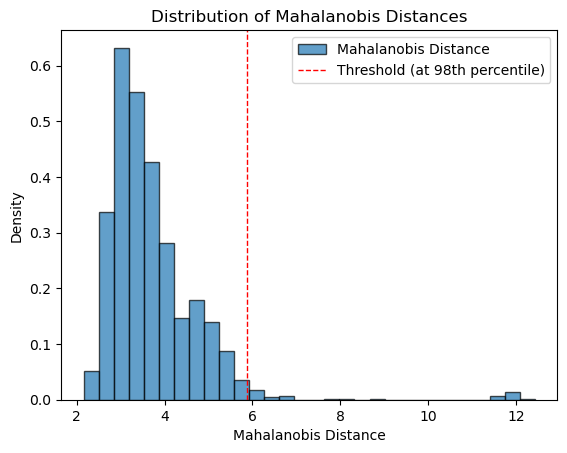

Outliers found
Number of outliers: 80


In [11]:
print(len(df_scaled))
fraction = 0.2  # 20% of the rows
df_unseen = df_scaled.sample(frac = fraction, random_state=42)

# Get the remaining 80% of the rows
df_seen = df_scaled.drop(df_unseen.index)
print(len(df_seen))



if filter_outliers:
    
    df_filtered = df_seen.copy()
    df_numeric = df_filtered.select_dtypes(include=[np.number]) # Select only numerical columns

    # Calculate the mean vector and covariance matrix
    mean_vector = df_numeric.mean(axis=0)
    cov_matrix = np.cov(df_numeric.values.T)

    # Add a small regularization term to the covariance matrix such that it's not singular
    # Since we are using classification data, 
    regularization_term = 1e-5 * np.eye(cov_matrix.shape[0])
    cov_matrix += regularization_term


    #--------- Compute the Mahalanobis distance for each observation
    def mahalanobis_distance(row, mean_vector, cov_matrix):

        '''
        The Mahalanobis distance assumes that the data follows a multivariate normal distribution. 

        1. Calculate the difference vector (diff) between the observation and the mean.
        2. Transpose the difference vector (diff.T).
        3. Multiply the transposed difference vector by the inverse covariance matrix (diff.T @ inv_cov_matrix).
        4. Multiply the result by the original difference vector (diff.T @ inv_cov_matrix @ diff).
        5. Take the square root of the result to get the Mahalanobis distance (md).
        '''

        diff = row - mean_vector
        inv_cov_matrix = np.linalg.inv(cov_matrix)
        md = np.sqrt(diff.T @ inv_cov_matrix @ diff) 
        return md

    # Apply the Mahalanobis distance function to each row
    # lamda makes row is a anonymous function that takes a single argument row, it is necessary to pass row as an argument to .apply
    # What apply sees is a function that takes a single argument, so it passes each row to this function
    df_filtered['mahalanobis'] = df_numeric.apply(lambda row: mahalanobis_distance(row, mean_vector, cov_matrix), axis=1) 
    print(df_filtered.head())

    #--------- Determine the threshold for identifying outliers
    percentile = 98
    threshold = np.percentile(df_filtered['mahalanobis'], percentile)
    print(f"Threshold (at {percentile}th percentile): {threshold}")


    # Plot the distribution of Mahalanobis distances
    plt.hist(df_filtered['mahalanobis'], bins=30, edgecolor='k', alpha=0.7, density=True, label='Mahalanobis Distance')

    # Add the threshold line
    plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold (at {percentile}th percentile)')

    # Add titles and labels
    plt.title('Distribution of Mahalanobis Distances')
    plt.xlabel('Mahalanobis Distance')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Identify outliers
    outliers = df_filtered[df_filtered['mahalanobis'] > threshold]
    
    if not outliers.empty:
        print("Outliers found")
        print(f"Number of outliers: {len(outliers)}")
    else:
        print("No outliers found")
    
    # Filter out the rows that contain outliers
    df_filtered = df_filtered[df_filtered['mahalanobis'] <= threshold]

    # Drop the 'mahalanobis' column as it's no longer needed
    df_filtered.drop(columns=['mahalanobis'], inplace=True)

else: 
    df_filtered = df_seen


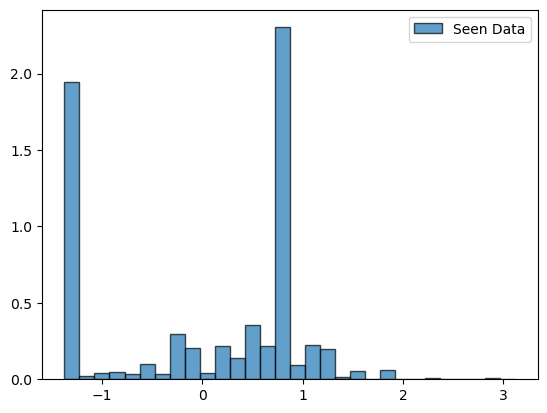

In [648]:

X_seen = df_filtered.iloc[:, 1:]
Y_seen = df_filtered.iloc[:, 0]

X_unseen = df_unseen.iloc[:, 1:]
Y_unseen = df_unseen.iloc[:, 0]

X_autograder = df_autograder_scaled

plt.hist(Y_seen, bins=30, edgecolor='k', alpha=0.7, density=True, label='Seen Data')
plt.legend()



### <font color="orange">  **Dummy model** </font>

In [649]:
from sklearn.dummy import DummyRegressor

def train_dummy_predictor(X, Y):
    model = DummyRegressor(strategy='mean')
    model.fit(X, Y)
    return model

### <font color="orange">  **KNN** </font>

In [650]:
from sklearn.neighbors import KNeighborsRegressor

def train_knn_regressor(X, Y, param_grid):
    model = KNeighborsRegressor(**param_grid)
    model.fit(X, Y)
    Y_pred = model.predict(X)
    loss_values = [mean_absolute_error(Y, Y_pred)]
    return model,loss_values

### <font color="orange">  **SGD** </font>

In [651]:
from sklearn.linear_model import SGDRegressor

def train_sgd_regressor(X, Y, params):
    model = SGDRegressor(**params)
    epochs = params['max_iter']

    loss_values = []
    for epoch in range(epochs):
        model.partial_fit(X, Y)
        Y_pred = model.predict(X)
        epoch_loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(epoch_loss)
    
    return model, loss_values

### <font color="orange">  **Decision Tree Regression** </font>

In [652]:
from sklearn.tree import DecisionTreeRegressor

def train_decision_tree_regressor(X, Y, params):

    '''params : dict
        Dictionary of parameters to pass to DecisionTreeRegressor.'''
    
    # splitter = Supported strategies are "best" to choose the best split and "random" to choose the best random split.
    # max_features = The number of features to consider when looking for the best split
    # min_samples_split = The minimum number of samples required to split an internal node
    # min_samples_leaf = The minimum number of samples required to be at a leaf node

    model = DecisionTreeRegressor(**params,random_state = 42)
    loss_values = []
    
    # Custom training loop with logging
    for depth in range(1, params['max_depth'] + 1):
        model.set_params(max_depth=depth)
        model.fit(X, Y)
        Y_pred = model.predict(X)
        loss = mean_absolute_error(Y, Y_pred)
        loss_values.append(loss)
    
    return model, loss_values

### <font color="orange">  **Grid Search** </font>

In [653]:
def grid_search(X, Y, model, param_grid, cv=5):
    
    # cv = It determines the cross-validation splitting strategy used to evaluate the performance of the model for each combination of hyperparameters
    # This means that the dataset will be split into 5 parts (folds). The model will be trained on 4 parts and tested on the remaining part.
    # This process will be repeated 5 times, each time with a different part as the test set.
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    
    # Fit the model
    print("Working on grid search")
    grid_search.fit(X, Y)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print(f"Best parameters: {best_params}")
    
    return best_model, best_params


X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size=0.2, random_state=42)

####################################################################
# ------ KNN REGRESSOR
print("------ KNN Regressor -----")
param_grid_KNN = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15 , 17, 19, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

model = KNeighborsRegressor()
best_model, best_params_KNN =  grid_search(X_train, Y_train, model, param_grid_KNN, cv=5)

####################################################################
# ------ DECISION TREE REGRESSOR
print("------ Decision Tree Regressor -----")
param_grid_Tree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'splitter': ['random'],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

model = DecisionTreeRegressor(random_state=42)
best_model, best_params_tree =  grid_search(X_train, Y_train, model, param_grid_Tree, cv=5)

####################################################################
# ------ SGD REGRESSOR
print("------ SGD Regressor -----")
param_grid_SGD = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.00001,0.0001], 'max_iter': [50,100, 200]
}

model = SGDRegressor(random_state=42)
best_model, best_params_SGD =  grid_search(X_train, Y_train, model, param_grid_SGD, cv=5)


------ KNN Regressor -----
Working on grid search
Best parameters: {'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
------ Decision Tree Regressor -----
Working on grid search
Best parameters: {'criterion': 'absolute_error', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'random'}
------ SGD Regressor -----
Working on grid search
Best parameters: {'alpha': 0.0001, 'eta0': 0.0001, 'learning_rate': 'adaptive', 'max_iter': 50, 'penalty': 'l2'}


### <font color="orange">  **Model training** </font>

In [654]:
print(f"Max Y_seen value: {Y_seen.max()}")
print(f"Min Y_seen value: {Y_seen.min()}")
print(f"Mean Y_seen value: {Y_seen.mean()}")
print("\n")


####################################################################
# ------ DUMMY PREDICTOR
print("------ Dummy Predictor -----")
model = train_dummy_predictor(X_train, Y_train)
Y_pred = model.predict(X_unseen)

loss = mean_absolute_error(Y_unseen, Y_pred)
print(f"Test Loss: {loss:.4f}")

Max Y_seen value: 3.1178705210175255
Min Y_seen value: -1.372319745743416
Mean Y_seen value: 0.010669220074817475


------ Dummy Predictor -----
Test Loss: 0.9205


In [655]:
####################################################################
# ------ KNN REGRESSOR
print("------ KNN Regressor -----")
KNN_model, training_loss_values = train_knn_regressor(X_train, Y_train, best_params_KNN)
Y_pred_KNN = KNN_model.predict(X_unseen)

loss = mean_absolute_error(Y_unseen, Y_pred_KNN)
print(f"Test Loss: {loss:.4f}")

------ KNN Regressor -----
Test Loss: 0.6325


------ Decision Tree Regressor -----
Test Loss: 0.6223




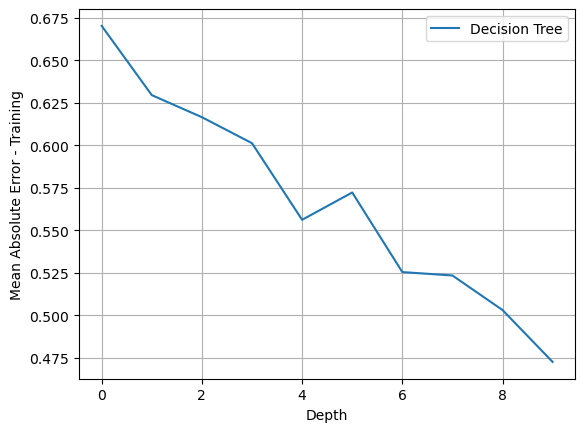

'decision_tree.pdf'

In [656]:
####################################################################
# ------ Decision Tree Regressor
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

print("------ Decision Tree Regressor -----")
Tree_model, training_loss_values = train_decision_tree_regressor(X_train, Y_train, best_params_tree)
Y_pred_Tree = Tree_model.predict(X_unseen)

loss = mean_absolute_error(Y_unseen, Y_pred_Tree)
print(f"Test Loss: {loss:.4f}")
print("\n")

plt.plot(training_loss_values, label='Decision Tree')
plt.xlabel('Depth')
plt.ylabel('Mean Absolute Error - Training')
plt.legend()
plt.grid()
plt.show()


# Export the decision tree to a DOT file
dot_data = export_graphviz(Tree_model, out_file=None, 
                           feature_names=X_train.columns,  
                           filled=True, rounded=True,  
                           special_characters=True,
                           impurity=True, proportion=True)  

# Convert the DOT file to a PDF
graph = graphviz.Source(dot_data)  
graph.render("decision_tree", format='pdf')



------ SGD Regressor -----
Test Loss: 0.6656


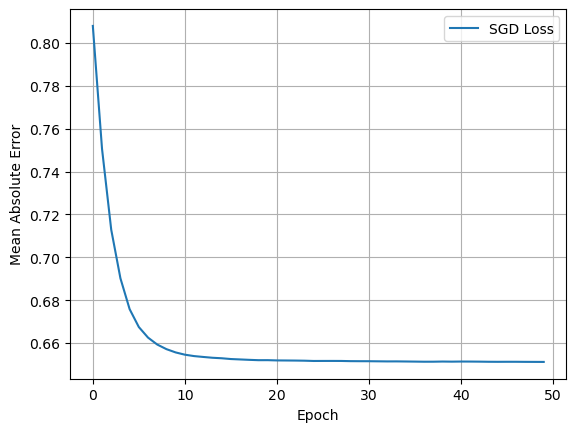

In [657]:
####################################################################
# ------ SGD Regressor
print("------ SGD Regressor -----")
SGD_model, training_loss_values_SGD = train_sgd_regressor(X_train, Y_train, best_params_SGD)
Y_pred_SGD = SGD_model.predict(X_unseen)

loss = mean_absolute_error(Y_unseen, Y_pred_SGD)
print(f"Test Loss: {loss:.4f}")

plt.plot(training_loss_values_SGD, label='SGD Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid()

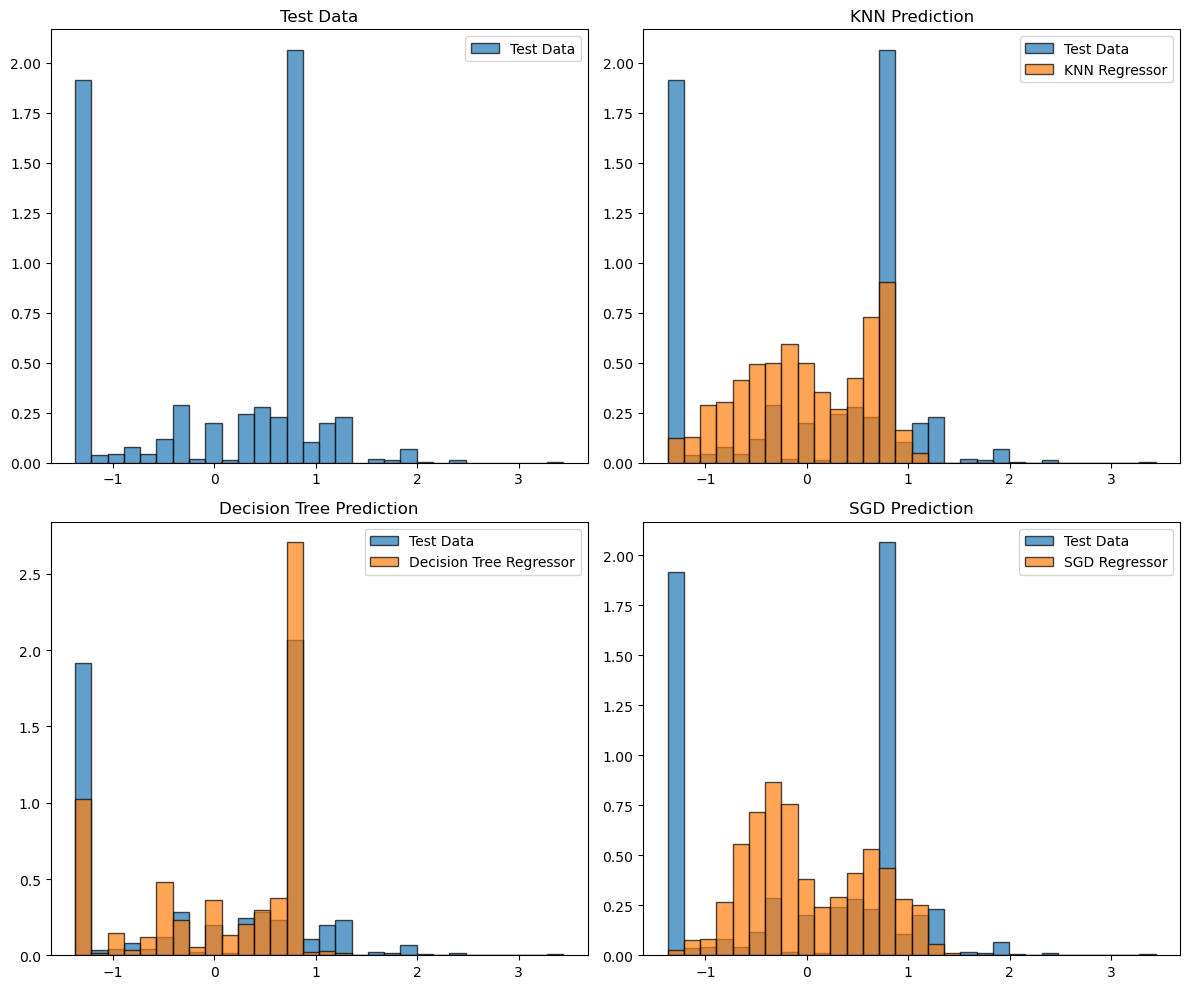

In [658]:
####################################################################
# Calculate histogram bins
counts, bin_edges = np.histogram(Y_unseen, bins=30)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot for Val Data
axs[0, 0].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
axs[0, 0].legend()
axs[0, 0].set_title('Test Data')

# Plot for KNN Prediction
axs[0, 1].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
axs[0, 1].hist(Y_pred_KNN, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='KNN Regressor')
axs[0, 1].legend()
axs[0, 1].set_title('KNN Prediction')

# Plot for Decision Tree Prediction
axs[1, 0].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
axs[1, 0].hist(Y_pred_Tree, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Decision Tree Regressor')
axs[1, 0].legend()
axs[1, 0].set_title('Decision Tree Prediction')

# Plot for SGD Prediction
axs[1, 1].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
axs[1, 1].hist(Y_pred_SGD, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='SGD Regressor')
axs[1, 1].legend()
axs[1, 1].set_title('SGD Prediction')

# Adjust layout
plt.tight_layout()
plt.show()

### <font color="orange">  **Ensemble training** </font>

In [659]:

def train_models(X_seen,Y_seen,params, model_train_function, n_models = 10, val_size = 0.2):

    models_training_loss = []
    models_val_loss = []
    model_list = []


    for n in range(n_models):
        X_train, X_val, Y_train, Y_val = train_test_split(X_seen, Y_seen, test_size= val_size, random_state= 42*n)

        model, loss_values = model_train_function(X_train, Y_train, params)
        
        model_list.append(model)
        models_training_loss.append(loss_values)

        Y_pred = model.predict(X_val)
        val_loss = mean_absolute_error(Y_val, Y_pred)
        models_val_loss.append(val_loss)
    
    return model_list, models_training_loss, models_val_loss


### <font color="orange">  **Ensemble training and validation test** </font>

In [660]:
# Create the DataFrame for ensemble
n_models = 30

Ensemble_val_loss = pd.DataFrame(index=range(n_models + 1))
Ensemble_val_loss.rename(index={n_models: 'mean'}, inplace=True)

print(Ensemble_val_loss)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, mean]


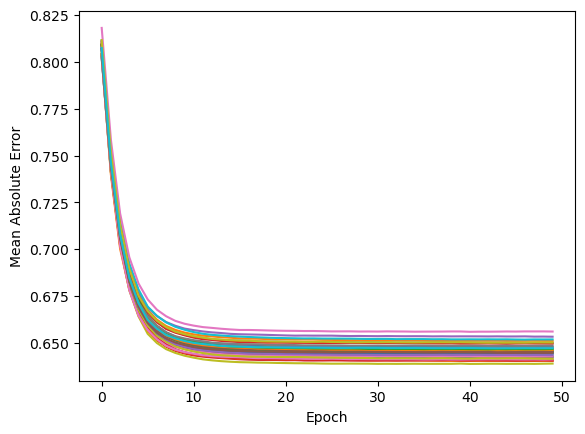

In [661]:
#############################
# ------SGD REGRESSOR
model_list_SGD, models_training_loss_SGD, models_val_loss_SGD = train_models(X_seen, Y_seen, best_params_SGD, train_sgd_regressor, n_models = n_models)
##############################

for loss_values in models_training_loss_SGD:
    plt.plot(loss_values)

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')

# Create the DataFrame with the mean in the end
Ensemble_val_loss.loc[:n_models - 1, 'SGD'] = models_val_loss_SGD
Ensemble_val_loss.loc['mean','SGD'] = Ensemble_val_loss['SGD'].mean()

In [662]:
#############################
# ------KNN REGRESSOR
model_list_KNN, models_training_loss,models_val_loss_KNN = train_models(X_seen, Y_seen, best_params_KNN, train_knn_regressor, n_models = n_models)

##############################

# Create the a column in the DataFrame with the mean in the end
Ensemble_val_loss.loc[:n_models - 1, 'KNN'] = models_val_loss_KNN
Ensemble_val_loss.loc['mean','KNN'] = Ensemble_val_loss['KNN'].mean()


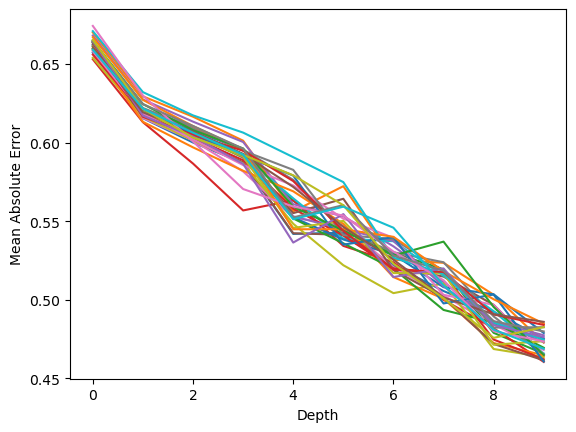

In [663]:
#############################
# ------DECISION TREE REGRESSOR
model_list_Tree, models_training_loss,models_val_loss_Tree = train_models(X_seen, Y_seen, best_params_tree, train_decision_tree_regressor, n_models = n_models)

for loss_values in models_training_loss:
    plt.plot(loss_values)
plt.xlabel('Depth')
plt.ylabel('Mean Absolute Error')

# Create the a column in the DataFrame with the mean in the end
Ensemble_val_loss.loc[:n_models - 1, 'Tree'] = models_val_loss_Tree
Ensemble_val_loss.loc['mean','Tree'] = Ensemble_val_loss['Tree'].mean()

In [664]:
# Set pandas display options to show more rows
pd.set_option('display.max_rows', 100)  # Adjust the number of rows

# Display the DataFrame
display(Ensemble_val_loss)

,SGD,KNN,Tree
0,0.66,0.62,0.61
1,0.63,0.61,0.58
2,0.66,0.63,0.61
3,0.67,0.64,0.59
4,0.62,0.61,0.54
5,0.66,0.62,0.57
6,0.66,0.63,0.58
7,0.65,0.62,0.58
8,0.67,0.63,0.63
9,0.65,0.62,0.62


In [665]:
if best_model_picker:
    top_models = 10

    # Find the index of the top best models on validation set
    top_models_index_KNN = Ensemble_val_loss['KNN'].sort_values().index[:top_models]
    top_models_index_SGD = Ensemble_val_loss['SGD'].sort_values().index[:top_models]
    top_models_index_tree = Ensemble_val_loss['Tree'].sort_values().index[:top_models]

    # Get the top best models
    top_models_KNN = [model_list_KNN[i] for i in top_models_index_KNN]
    top_models_SGD = [model_list_SGD[i] for i in top_models_index_SGD]
    top_models_Tree = [model_list_Tree[i] for i in top_models_index_tree]

else:
    top_models_KNN = model_list_KNN
    top_models_SGD = model_list_SGD
    top_models_Tree = model_list_Tree




### <font color="orange">  **Ensemble test** </font>

In [666]:
def esemble_test(model_list, X_unseen, Y_unseen):
    Y_pred_list = []
    for model in model_list:
        Y_pred = model.predict(X_unseen)
        Y_pred_list.append(Y_pred)

    Y_pred_list = np.mean(Y_pred_list, axis=0)
    test_loss = mean_absolute_error(Y_unseen, Y_pred_list)

    return test_loss,Y_pred_list


KNN_avg_test_loss,KNN_test_pred_list = esemble_test(top_models_KNN, X_unseen, Y_unseen)
print(f"KNN - Test Loss: {KNN_avg_test_loss:.4f}")

SGD_avg_test_loss, SGD_test_pred_list = esemble_test(top_models_SGD, X_unseen, Y_unseen)
print(f"SGD - Test Loss: {SGD_avg_test_loss:.4f}")

Forest_test_loss, Forest_test_pred_list = esemble_test(top_models_Tree, X_unseen, Y_unseen)
print(f"Random Forest - Test Loss: {Forest_test_loss:.4f}")


#############################
#---- SUPER ENSEMBLE PREDICTION
Sper_ensemble_pred = (KNN_test_pred_list + SGD_test_pred_list + Forest_test_pred_list) / 3
Super_ensemble_test_loss = mean_absolute_error(Y_unseen, Sper_ensemble_pred)
print(f"Super Ensemble - Test Loss: {Super_ensemble_test_loss:.4f}")


# Create a DataFrame to store the predictions
Ensemble_test_losses = pd.DataFrame()
Ensemble_test_losses['KNN'] = [KNN_avg_test_loss]
Ensemble_test_losses['SGD'] = [SGD_avg_test_loss]
Ensemble_test_losses['Tree'] = [Forest_test_loss]

#Rename 

display(Ensemble_test_losses)


#0.5697 train 30 pick 10

KNN - Test Loss: 0.6264
SGD - Test Loss: 0.6639
Random Forest - Test Loss: 0.5932
Super Ensemble - Test Loss: 0.6175


,KNN,SGD,Tree
0,0.63,0.66,0.59


### <font color="orange">  **Logistic adjustment** </font>

Forest Test Loss: 0.5979
SGD Test Loss: 0.5604
KNN Test Loss: 0.5832
Super Ensemble Test Loss: 0.6175


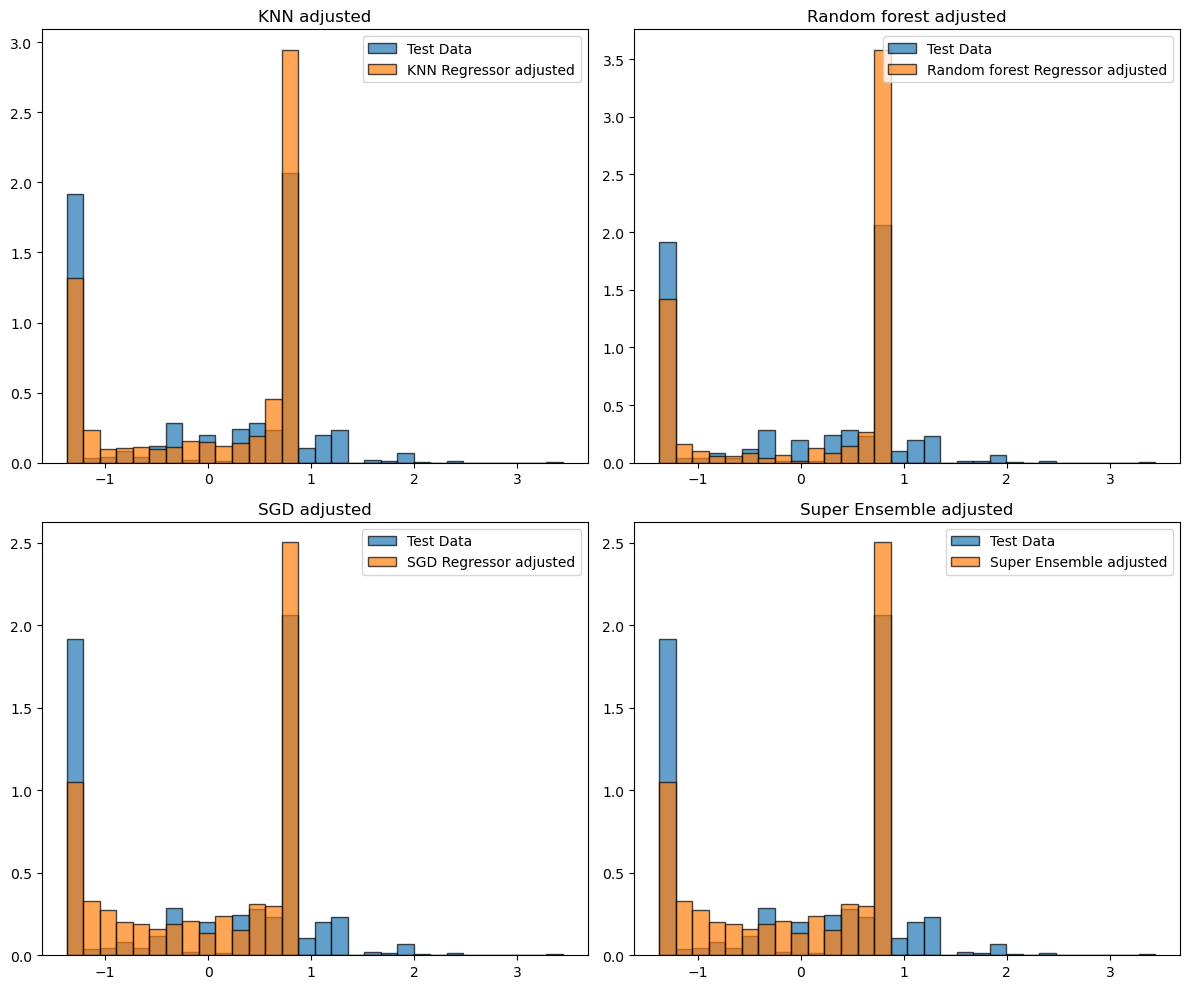

In [667]:
def soft_max_adjustnent(value, target1 = -Y_mean/Y_std, target2= (40-Y_mean)/Y_std , gamma=5):

    # Calculate the distance to each target
    dist_to_target1 = abs(value - target1)
    dist_to_target2 = abs(value - target2)
    
    # Transform the distance to probability
    # Assumed the distance follows a Exponential distribution
    prob_target1 = np.exp(-gamma * dist_to_target1)
    prob_target2 = np.exp(-gamma * dist_to_target2)
    
    # Normalize the probabilities using soft max
    total_prob = prob_target1 + prob_target2
    prob_target1 /= total_prob
    prob_target2 /= total_prob
    
    # Adjust the value based on the probabilities
    adjusted_value = prob_target1 * target1 + prob_target2 * target2
    
    return adjusted_value

if logistic_adjustment:
    Forest_test_pred_list_adjusted = []

    for i in range(len(Forest_test_pred_list)):
        Forest_test_pred_list_adjusted.append(soft_max_adjustnent(Forest_test_pred_list[i]))


    SGD_test_pred_list_adjusted = []

    for i in range(len(SGD_test_pred_list)):
        SGD_test_pred_list_adjusted.append(soft_max_adjustnent(SGD_test_pred_list[i]))

    KNN_test_pred_list_adjusted = []

    for i in range(len(KNN_test_pred_list)):
        KNN_test_pred_list_adjusted.append(soft_max_adjustnent(KNN_test_pred_list[i]))

    Sper_ensemble_pred_adjusted = []
    for i in range(len(Sper_ensemble_pred)):
        Sper_ensemble_pred_adjusted.append(soft_max_adjustnent(Sper_ensemble_pred[i]))


    print(f'Forest Test Loss: {mean_absolute_error(Y_unseen, Forest_test_pred_list_adjusted):.4f}')
    print(f'SGD Test Loss: {mean_absolute_error(Y_unseen, SGD_test_pred_list_adjusted):.4f}')
    print(f'KNN Test Loss: {mean_absolute_error(Y_unseen, KNN_test_pred_list_adjusted):.4f}')
    print(f'Super Ensemble Test Loss: {mean_absolute_error(Y_unseen, Sper_ensemble_pred):.4f}')



    ####################################################################
    # Calculate histogram bins
    counts, bin_edges = np.histogram(Y_unseen, bins=30)

    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot for KNN Prediction
    axs[0, 0].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[0, 0].hist(KNN_test_pred_list_adjusted, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='KNN Regressor adjusted')
    axs[0, 0].legend()
    axs[0, 0].set_title('KNN adjusted')

    # Plot for Decision Tree Prediction
    axs[0, 1].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[0, 1].hist(Forest_test_pred_list_adjusted, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Random forest Regressor adjusted')
    axs[0, 1].legend()
    axs[0, 1].set_title('Random forest adjusted')

    # Plot for SGD Prediction
    axs[1, 0].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[1, 0].hist(SGD_test_pred_list_adjusted, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='SGD Regressor adjusted')
    axs[1, 0].legend()
    axs[1, 0].set_title('SGD adjusted')

    #PLot for Super Ensemble
    axs[1, 1].hist(Y_unseen, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Test Data')
    axs[1, 1].hist(SGD_test_pred_list_adjusted, bins=bin_edges, edgecolor='k', alpha=0.7, density=True, label='Super Ensemble adjusted')
    axs[1, 1].legend()
    axs[1, 1].set_title('Super Ensemble adjusted')


    # Adjust layout
    plt.tight_layout()
    plt.show()
